In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import bitstring
from qiskit_aer import AerSimulator
from qiskit.transpiler.passes.synthesis import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations
from qiskit.quantum_info import Operator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [2]:
#algorithm for that shit        ,       n=null, e=eins

nn = ["0000","1111"]
ne = ["0011","1100"]
en = ["0101","1010"]
ee = ["0110","1001"]

def idk(new: list, a: list, b:list, c:list):
    for i in a:
        for j in b:
            for k in c:
                new.append(i+j+k)

#noisefree gates
matrix_h = ([[2**(-0.5),2**(-0.5)],[2**(-0.5),-2**(-0.5)]])
h_ideal = UnitaryGate(matrix_h)

matrix_cx = ([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
cx_ideal = UnitaryGate(matrix_cx)       #Erst Target, dann Control Qubit!!

matrix_x = ([[0,1],[1,0]])
x_ideal = UnitaryGate(matrix_x)

matrix_z = ([[1,0],[0,-1]])
z_ideal = UnitaryGate(matrix_z)

In [16]:
def idk(new: list, a: list, b:list, c:list):
    for i in a:
        for j in b:
            for k in c:
                new.append(i+j+k)

def code():                                     #intialize |00> state
    qr = QuantumRegister(15,"q")
    cbits = ClassicalRegister(29,"c")             #12(Auslesen am Ende) + 7(Preselection) + 5(Stabilizers) = 24 insgesamt
    qc = QuantumCircuit(qr, cbits)

    q = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

    for i in range(12):
        qc.id(i)

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(7)
    qc.h(11)
    qc.h(12)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)


    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)

    qc.cx(7,4)
    qc.cx(7,5)
    qc.cx(7,6)

    qc.cx(11,8)
    qc.cx(11,9)
    qc.cx(11,10)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)

    qc.h(12)
    qc.id(12)
    qc.measure(12,0)
    qc.id(13)
    qc.measure(13,1)
    qc.id(14)
    qc.measure(14,2)

    qc.reset(12)
    qc.reset(13)
    qc.reset(14)
    ####################################################
    for i in range(8):
        qc.cx(i,i+4)
    ####################################################
    qc.h(12)

    qc.cx(12,4)
    qc.cx(7,13)
    qc.cx(12,7)
    qc.cx(4,13)
    qc.cx(12,5)
    qc.cx(6,13)
    qc.cx(12,6)
    qc.cx(5,13)

    qc.h(12)
    qc.id(12)
    qc.measure(12,3)
    qc.id(13)
    qc.measure(13,4)

    qc.reset(12)
    qc.reset(13)
    
    ####################################################
    qc.h(12)

    qc.cx(12,13)
    qc.cx(8,13)
    qc.cx(10,12)
    qc.cx(9,12)
    qc.cx(11,13)
    qc.cx(12,13)

    qc.h(12)
    qc.id(12)
    qc.measure(12,5)
    qc.id(13)
    qc.measure(13,6)

    qc.reset(12)
    qc.reset(13)

    q[5],q[7] = q[7],q[5]
    q[6],q[7] = q[7],q[6]

    q[9],q[10] = q[10],q[9]
    q[10],q[11] = q[11],q[10]
    
    return qc, q

def X_L(qc: QuantumCircuit, q: list, pos: int):
    qc.x(q[3])
    qc.x(q[10])
    if pos == 0:
        qc.x(q[0])
        qc.x(q[11])
    elif pos == 1:
        qc.x(q[1])
        qc.x(q[9])

def Z_L(qc: QuantumCircuit, q: list, pos: int):
    qc.z(q[0])
    qc.z(q[9])
    if pos == 0:
        qc.z(q[3])
        qc.z(q[11])
    elif pos == 1:
        qc.z(q[1])
        qc.z(q[10])

def CNOT_L(qc: QuantumCircuit, q: list, control = 0):
    for i in range(4):
        q[i], q[i+8] = q[i+8], q[i]
    
    if control == 0:
        q[0], q[1] = q[1], q[0]
        q[4], q[5] = q[5], q[4]
        q[8], q[9] = q[9], q[8]
    else:
        q[0], q[2] = q[2], q[0]
        q[4], q[6] = q[6], q[4]
        q[8], q[10] = q[10], q[8]

def H_L(qc: QuantumCircuit, q: list, pos: int):                 #state injection vom hadamard für einzelnes hadamard
    anc = qc.num_qubits - 1
    if pos != 2:
        qc.reset(anc)
    
        Z_L(qc, q, pos=pos)

        if pos == 0:                  #hier zu Z_L
            qc.append(cx_ideal, [anc,q[0]])
            qc.append(cx_ideal, [anc,q[3]])
            qc.append(cx_ideal, [anc,q[9]])
            qc.append(cx_ideal, [anc,q[11]])
        elif pos == 1:
            qc.append(cx_ideal, [anc,q[0]])
            qc.append(cx_ideal, [anc,q[1]])
            qc.append(cx_ideal, [anc,q[9]])
            qc.append(cx_ideal, [anc,q[10]])
        qc.append(h_ideal,[anc])
        if pos == 0:
            qc.append(cx_ideal, [q[0],anc])
            qc.append(cx_ideal, [q[3],anc])
            qc.append(cx_ideal, [q[10],anc])
            qc.append(cx_ideal, [q[11],anc])
        elif pos == 1:
            qc.append(cx_ideal, [q[1],anc])
            qc.append(cx_ideal, [q[3],anc])
            qc.append(cx_ideal, [q[9],anc])
            qc.append(cx_ideal, [q[10],anc])
        qc.append(h_ideal,[anc])
        qc.measure(anc, 7)
        if pos == 0:                        #hier zu X_L
            with qc.if_test((7,1)):
                qc.z(q[0])
                qc.z(q[3])
                qc.z(q[9])
                qc.z(q[11])

                qc.x(q[0])
                qc.x(q[3])
                qc.x(q[10])
                qc.x(q[11])
            #q[9], q[10] = q[10], q[9]
        elif pos == 1:
            with qc.if_test((7,1)):
                qc.z(q[0])
                qc.z(q[1])
                qc.z(q[9])
                qc.z(q[10])

                qc.x(q[1])
                qc.x(q[3])
                qc.x(q[9])
                qc.x(q[10])
            #q[0], q[3] = q[3], q[0]
    if pos == 2:
        for i in range(12):
            qc.h(q[i])
        q[0], q[3] = q[3], q[0]
        q[5], q[6] = q[6], q[5]
        q[9], q[10] = q[10], q[9]

def CZ_L(qc: QuantumCircuit, q:list):
    H_L(qc, q, 0)
    CNOT_L(qc, q, 1)
    H_L(qc, q, 0)

def S_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    qc.append(h_ideal,[anc])
    qc.s(anc)
    if pos == 0:                        #zu Z_L
        qc.append(cx_ideal, [anc,q[0]])
        qc.append(cx_ideal, [anc,q[3]])
        qc.append(cx_ideal, [anc,q[9]])
        qc.append(cx_ideal, [anc,q[11]])
    elif pos == 1:
        qc.append(cx_ideal, [anc,q[0]])
        qc.append(cx_ideal, [anc,q[1]])
        qc.append(cx_ideal, [anc,q[9]])
        qc.append(cx_ideal, [anc,q[10]])

    qc.measure(anc,7)
    if pos == 0:
        with qc.if_test((7,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[3])
            qc.z(q[11])
    elif pos == 1:
        with qc.if_test((7,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[1])
            qc.z(q[10])

def adj_S_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    qc.append(h_ideal,[anc])
    qc.sdg(anc)

    if pos == 0:                        #zu Z_L
        qc.append(cx_ideal, [anc,q[0]])
        qc.append(cx_ideal, [anc,q[3]])
        qc.append(cx_ideal, [anc,q[9]])
        qc.append(cx_ideal, [anc,q[11]])
    elif pos == 1:
        qc.append(cx_ideal, [anc,q[0]])
        qc.append(cx_ideal, [anc,q[1]])
        qc.append(cx_ideal, [anc,q[9]])
        qc.append(cx_ideal, [anc,q[10]])

    qc.measure(anc,7)
    if pos == 0:
        with qc.if_test((7,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[3])
            qc.z(q[11])
    elif pos == 1:
        with qc.if_test((7,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[1])
            qc.z(q[10])

def T_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    qc.append(h_ideal,[anc])
    qc.t(anc)

    if pos == 0:                        #zu Z_L
        qc.append(cx_ideal, [anc,q[0]])
        qc.append(cx_ideal, [anc,q[3]])
        qc.append(cx_ideal, [anc,q[9]])
        qc.append(cx_ideal, [anc,q[11]])
    elif pos == 1:
        qc.append(cx_ideal, [anc,q[0]])
        qc.append(cx_ideal, [anc,q[1]])
        qc.append(cx_ideal, [anc,q[9]])
        qc.append(cx_ideal, [anc,q[10]])
    qc.measure(anc,7)
    if pos == 0:
        with qc.if_test((7,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.s(anc)
            qc.append(cx_ideal, [anc,q[0]])
            qc.append(cx_ideal, [anc,q[3]])
            qc.append(cx_ideal, [anc,q[9]])
            qc.append(cx_ideal, [anc,q[11]])
            qc.measure(anc,7)
            with qc.if_test((7,1)):
                qc.z(q[0])
                qc.z(q[3])
                qc.z(q[9])
                qc.z(q[11])
    elif pos == 1:
        with qc.if_test((7,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.s(anc)
            qc.append(cx_ideal, [anc,q[0]])
            qc.append(cx_ideal, [anc,q[1]])
            qc.append(cx_ideal, [anc,q[9]])
            qc.append(cx_ideal, [anc,q[10]])
            qc.measure(anc,7)
            with qc.if_test((7,1)):
                qc.z(q[0])
                qc.z(q[1])
                qc.z(q[9])
                qc.z(q[10])

def adj_T_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    qc.append(h_ideal,[anc])
    qc.tdg(anc)

    if pos == 0:                        #zu Z_L
        qc.append(cx_ideal, [anc,q[0]])
        qc.append(cx_ideal, [anc,q[3]])
        qc.append(cx_ideal, [anc,q[9]])
        qc.append(cx_ideal, [anc,q[11]])
    elif pos == 1:
        qc.append(cx_ideal, [anc,q[0]])
        qc.append(cx_ideal, [anc,q[1]])
        qc.append(cx_ideal, [anc,q[9]])
        qc.append(cx_ideal, [anc,q[10]])

    qc.measure(anc,7)
    if pos == 0:
        with qc.if_test((7, 1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.sdg(anc)
            qc.append(cx_ideal, [anc,q[0]])
            qc.append(cx_ideal, [anc,q[3]])
            qc.append(cx_ideal, [anc,q[9]])
            qc.append(cx_ideal, [anc,q[11]])
            qc.measure(anc,7)
            with qc.if_test((7 ,1)):
                qc.z(q[0])
                qc.z(q[3])
                qc.z(q[9])
                qc.z(q[11])
    elif pos == 1:
        with qc.if_test((7, 1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.sdg(anc)
            qc.append(cx_ideal, [anc,q[0]])
            qc.append(cx_ideal, [anc,q[1]])
            qc.append(cx_ideal, [anc,q[9]])
            qc.append(cx_ideal, [anc,q[10]])
            qc.measure(anc,7)
            with qc.if_test((7, 1)):
                qc.z(q[0])
                qc.z(q[1])
                qc.z(q[9])
                qc.z(q[10])

circ = QuantumCircuit(1)
circ.rz(np.pi/8, 0)
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
rootT = skd(circ)

def root_T_L(qc: QuantumCircuit, q: list, pos: int, m: list, tracker):
    instruction = rootT.data
    for i in instruction:
        if i.name == "t":
            T_L(qc, q, pos=pos)
        if i.name == "tdg":
            adj_T_L(qc, q, pos=pos)
        if i.name == "h":
            H_L(qc, q, pos=pos)

circ = QuantumCircuit(1)
circ.rz(-np.pi/8, 0)
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
rootadjT = skd(circ)

def adj_root_T_L(qc: QuantumCircuit, q: list, pos: int, m:list, tracker):
    instruction = rootadjT.data
    for i in instruction:
        if i.name == "t":
            T_L(qc, q, pos=pos)
        if i.name == "tdg":
            adj_T_L(qc, q, pos=pos)
        if i.name == "h":
            H_L(qc, q, pos=pos)

# def U2(qc: QuantumCircuit, q: list, pos: int):
#     gate = ['s', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'sdg', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 's', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't']
#     for i in gate:
#         if i == "s":
#             S_L(qc, q, pos=pos)
#         if i == "sdg":
#             adj_S_L(qc, q, pos=pos)
#         if i == "t":
#             T_L(qc, q, pos=pos)
#         if i == "tdg":
#             adj_T_L(qc, q, pos=pos)
#         if i == "h":
#             H_L(qc, q, pos=pos)

# def adjU2(qc: QuantumCircuit, q: list, pos: int):
#     gate = ['s', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'sdg', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 's', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't']
#     gate.reverse()
#     for i in gate:
#         if i == "sdg":
#             S_L(qc, q, pos=pos)
#         if i == "s":
#             adj_S_L(qc, q, pos=pos)
#         if i == "tdg":
#             T_L(qc, q, pos=pos)
#         if i == "t":
#             adj_T_L(qc, q, pos=pos)
#         if i == "h":
#             H_L(qc, q, pos=pos)

# def CU_L(qc: QuantumCircuit, q: list, n: list, tracker, err = False):
#     if err:
#         qec_ft(qc, q, tracker)
#     U2(qc, q, 0)
#     if err:
#         qec_ft(qc, q, tracker)
#     U2(qc, q, 1)
#     CNOT_L(qc, q, 0)
#     if err:
#         qec_ft(qc, q, tracker)
#     adjU2(qc, q, 1)
#     CNOT_L(qc, q, 0)

def convert(bin: str):                  #konvertiert den bitstring in decimal, e.g. 0110 = 0.375
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n

def U2(qc: QuantumCircuit, q:list, pos: int, gate: list):
    for i in gate:
        if i == "s":
            S_L(qc, q, pos=pos)
        if i == "sdg":
            adj_S_L(qc, q, pos=pos)
        if i == "t":
            T_L(qc, q, pos=pos)
        if i == "tdg":
            adj_T_L(qc, q, pos=pos)
        if i == "h":
            H_L(qc, q, pos=pos)
        if i == "z":
            Z_L(qc, q ,pos=pos)

def CU_L(qc: QuantumCircuit, q:list, Ugates: list, adjUgates: list, tracker, err = False):
    U2(qc, q, 0, Ugates)
    if err:
        qec_ft(qc, q, tracker)
    U2(qc, q, 1, Ugates)
    if err:
        qec_ft(qc, q, tracker)
    CNOT_L(qc, q, 0)
    U2(qc, q, 1, adjUgates)
    if err:
        qec_ft(qc, q, tracker)
    CNOT_L(qc, q, 0)

def Leon(iter: int, n:int, argh: float, err = False, k = 1):       #each iteration own circuit
    angle = np.linspace(0,1,n+2)
    angle = np.delete(angle, [n+1])
    angle = np.delete(angle, [0])

    a, b = [], []
    with open("Unitary/unitary{}.txt".format(n), "r") as file:
        for line in file:
            a.append(list(map(str, line.strip().split(","))))
    with open("Unitary/adjunitary{}.txt".format(n), "r") as file:
        for line in file:
            b.append(list(map(str, line.strip().split(","))))
    
    y = 0
    bruh1 = []
    for m in range(k):
        for o in range(n):
            bitstring = ""
            rots = []
            for t in range(iter):
                rots = [k*0.5 for k in rots]
                while True:
                    qc, q, tracker = code_ft() 

                    X_L(qc, q, 1)
                    H_L(qc, q, 0)
                    #############################
                    for j in range(2**(iter-t-1)):
                        CU_L(qc, q, a[o], b[o], tracker, err=err)
                    ###############################

                    for l in rots:
                        if l == 0.25:
                            adj_S_L(qc, q, pos=0)
                        if l == 0.125:
                            adj_T_L(qc, q, pos=0)

                    H_L(qc, q, 0)

                    counts, cbits = readout(qc, 1, q, noise=argh)
                    result = fullpp_ft(counts, 1, cbits, tracker, True)                     #[preselected, twoqubiterr, post, nullnull, nulleins, einsnull, einseins]
                    if result[3] != 0:
                        bitstring += "0"
                        break
                    if result[4] != 0:
                        bitstring += "0"
                        break
                    if result[5] != 0:
                        bitstring += "1"
                        rots.append(0.5)
                        break
                    if result[6] != 0:
                        bitstring += "1"
                        rots.append(0.5)
                        break
            bitstring = bitstring[::-1]
            hmm = convert(bitstring)
            diff = np.abs(hmm-angle[o])
            y += diff
            bruh1.append(diff)
    y = y/(n*k)
    arg = 0
    for i in range(len(bruh1)):
        arg += (y-bruh1[i])**2
    sigma = ((1/(k*n))*arg)**0.5
    sigma = sigma/((k*n)**0.5)

    return y, sigma

def CT_L(qc: QuantumCircuit, q: list, n: list, tracker, err = False):
    # if err:
    #     qec_ft(qc, q, tracker)
    root_T_L(qc, q, 0, n, tracker)
    if err:
        qec_ft(qc, q, tracker)
    root_T_L(qc, q, 1, n, tracker)
    CNOT_L(qc, q, 0)
    # if err:
    #     qec_ft(qc, q, tracker)
    adj_root_T_L(qc, q, 1, n, tracker)
    CNOT_L(qc, q, 0)

def CS_L(qc: QuantumCircuit, q: list):
    T_L(qc, q, 0)
    T_L(qc, q, 1)
    CNOT_L(qc, q, 0)
    adj_T_L(qc, q, 1)
    CNOT_L(qc, q, 0)

def qec(qc: QuantumCircuit, q: list):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    #####################Bitflip Error Stabilizer messen########################################
    for k in range(1):

        #S2 Stabilizers
        for i in range(4):
            qc.cx(q[i], anc)
        qc.measure(anc, 19)
        qc.reset(anc)

        #S4 Stabilizer
        for i in range(4):
            qc.cx(q[i+4], anc)
        qc.measure(anc, 20)
        qc.reset(anc)

        #S6 Stabilizer
        for i in range(4):
            qc.cx(q[i+8], anc)
        qc.measure(anc, 21)
        qc.reset(anc)

        #S9 Stabilizer
        qc.cx(q[0],anc)
        qc.cx(q[2],anc)
        qc.cx(q[6],anc)
        qc.cx(q[7],anc)
        qc.cx(q[8],anc)
        qc.cx(q[11],anc)
        qc.measure(anc, 22)
        qc.reset(anc)

        #S10 Stabilizer
        qc.cx(q[0],anc)
        qc.cx(q[3],anc)
        qc.cx(q[4],anc)
        qc.cx(q[6],anc)
        qc.cx(q[10],anc)
        qc.cx(q[11],anc)
        qc.measure(anc, 23)
        qc.reset(anc)

        with qc.if_test((19,1)):            #X0
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.x(q[0])

        with qc.if_test((19,1)):            #X1
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.x(q[1])

        with qc.if_test((19,1)):            #X2
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.x(q[2])

        with qc.if_test((19,1)):            #X3
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.x(q[3])

        with qc.if_test((20,1)):            #X4
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.x(q[4])

        with qc.if_test((20,1)):            #X5
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.x(q[5])

        with qc.if_test((20,1)):            #X6
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.x(q[6])

        with qc.if_test((20,1)):            #X7
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.x(q[7])

        with qc.if_test((21,1)):            #X8
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.x(q[8])
        
        with qc.if_test((21,1)):            #X9
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.x(q[9])
        
        with qc.if_test((21,1)):            #X10
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.x(q[10])

        with qc.if_test((21,1)):            #X11
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.x(q[11])

    ###################Phaseflip Error Stabilizers############################
    for k in range(1):
        #S1 Stabilizers
        qc.h(anc)
        for i in range(4):
            qc.cx(anc, q[i])
        qc.h(anc)
        qc.measure(anc, 24)
        qc.reset(anc)

        #S3 Stabilizer
        qc.h(anc)
        for i in range(4):
            qc.cx(anc, q[i+4])
        qc.h(anc)
        qc.measure(anc, 25)
        qc.reset(anc)

        #S5 Stabilizer
        qc.h(anc)
        for i in range(4):
            qc.cx(anc, q[i+8])
        qc.h(anc)
        qc.measure(anc, 26)
        qc.reset(anc)

        #S7 Stabilizer
        qc.h(anc)
        qc.cx(anc, q[0])
        qc.cx(anc, q[1])
        qc.cx(anc, q[5])
        qc.cx(anc, q[7])
        qc.cx(anc, q[8])
        qc.cx(anc, q[11])
        qc.h(anc)
        qc.measure(anc, 27)
        qc.reset(anc)

        #S8 Stabilizer
        qc.h(anc)
        qc.cx(anc, q[0])
        qc.cx(anc, q[3])
        qc.cx(anc, q[4])
        qc.cx(anc, q[5])
        qc.cx(anc, q[9])
        qc.cx(anc, q[11])
        qc.h(anc)
        qc.measure(anc, 28)
        qc.reset(anc)

        with qc.if_test((24,1)):            #Z0
            with qc.if_test((27,1)):
                with qc.if_test((28,1)):
                    qc.z(q[0])

        with qc.if_test((24,1)):            #Z1
            with qc.if_test((27,1)):
                with qc.if_test((28,0)):
                    qc.z(q[1])

        with qc.if_test((24,1)):            #Z2
            with qc.if_test((27,0)):
                with qc.if_test((28,0)):
                    qc.z(q[2])

        with qc.if_test((24,1)):            #Z3
            with qc.if_test((27,0)):
                with qc.if_test((28,1)):
                    qc.z(q[3])

        with qc.if_test((25,1)):            #Z4
            with qc.if_test((27,0)):
                with qc.if_test((28,1)):
                    qc.z(q[4])

        with qc.if_test((25,1)):            #Z5
            with qc.if_test((27,1)):
                with qc.if_test((28,1)):
                    qc.z(q[5])

        with qc.if_test((25,1)):            #Z6
            with qc.if_test((27,0)):
                with qc.if_test((28,0)):
                    qc.z(q[6])

        with qc.if_test((25,1)):            #Z7
            with qc.if_test((27,1)):
                with qc.if_test((28,0)):
                    qc.z(q[7])

        with qc.if_test((26,1)):            #Z8
            with qc.if_test((27,1)):
                with qc.if_test((28,0)):
                    qc.z(q[8])
        
        with qc.if_test((26,1)):            #Z9
            with qc.if_test((27,0)):
                with qc.if_test((28,1)):
                    qc.z(q[9])
        
        with qc.if_test((26,1)):            #Z10
            with qc.if_test((27,0)):
                with qc.if_test((28,0)):
                    qc.z(q[10])

        with qc.if_test((26,1)):            #Z11
            with qc.if_test((27,1)):
                with qc.if_test((28,1)):
                    qc.z(q[11])

def readout_anders_lol(qc: QuantumCircuit, shots: int, q: list, noise = 0):      #einfacher ablesblar, was genau ich messe, aber macht das selbe
    for i in range(12):
        qc.measure(q[i],18-i)
    
    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "id"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    # depolarizing_prob = noise
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)

    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","sdg"])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

    sim = AerSimulator()
    job = sim.run(qc, shots=shots, noise_model = noise_model)
    result = job.result()
    counts = result.get_counts()
    
    nn = ["0000","1111"]
    ne = ["0011","1100"]
    en = ["0101","1010"]
    ee = ["0110","1001"]

    zerozero = ["000","123","231","312"]
    zeroone = ["203","320","032","111"]
    onezero = ["301","222","130","013"]
    oneone = ["102","021","333","210"]

    bitstring = list(counts.keys())
    hmm = list(counts.values())

    pre, preselected = [i[12:] for i in bitstring], 0
    bits = [i[:12] for i in bitstring]

    C4_1 = [i[:4] for i in bits]
    C4_2 = [i[4:8] for i in bits]
    C4_3 = [i[8:12] for i in bits]

    test = []

    for i in range(len(pre)):
        if pre[i].count("1") != 0:
            bits[i] = "pre"
            preselected += hmm[i]

    for i in range(len(C4_1)):
        for j in nn:
            if j == C4_1[i]:
                C4_1[i] = "0"
                break
        if C4_1[i] != 0:
            for j in ne:
                if j == C4_1[i]:
                    C4_1[i] = "1"
                    break
        if C4_1[i] != 1 and C4_1[i] != 0:
            for j in en:
                if j == C4_1[i]:
                    C4_1[i] = "2"
                    break
        if C4_1[i] != 2 and C4_1[i] != 1 and C4_1[i] != 0:
            for j in ee:
                if j == C4_1[i]:
                    C4_1[i] = "3"
                    break
        if C4_1[i] != "0" and C4_1[i] != "1" and C4_1[i] != "2" and C4_1[i] != "3":
            bits[i] = "post"

    for i in range(len(C4_2)):
        for j in nn:
            if j == C4_2[i]:
                C4_2[i] = "0"
                break
        if C4_2[i] != 0:
            for j in ne:
                if j == C4_2[i]:
                    C4_2[i] = "1"
                    break
        if C4_2[i] != 1 and C4_2[i] != 0:
            for j in en:
                if j == C4_2[i]:
                    C4_2[i] = "2"
                    break
        if C4_2[i] != 2 and C4_2[i] != 1 and C4_2[i] != 0:
            for j in ee:
                if j == C4_2[i]:
                    C4_2[i] = "3"
                    break
        if C4_2[i] != "0" and C4_2[i] != "1" and C4_2[i] != "2" and C4_2[i] != "3":
            bits[i] = "post"

    for i in range(len(C4_3)):
        for j in nn:
            if j == C4_3[i]:
                C4_3[i] = "0"
                break
        if C4_3[i] != 0:
            for j in ne:
                if j == C4_3[i]:
                    C4_3[i] = "1"
                    break
        if C4_3[i] != 1 and C4_3[i] != 0:
            for j in en:
                if j == C4_3[i]:
                    C4_3[i] = "2"
                    break
        if C4_3[i] != 2 and C4_3[i] != 1 and C4_3[i] != 0:
            for j in ee:
                if j == C4_3[i]:
                    C4_3[i] = "3"
                    break
        if C4_3[i] != "0" and C4_3[i] != "1" and C4_3[i] != "2" and C4_3[i] != "3":
            bits[i] = "post"

    for i in range(len(C4_1)):
        ehm = C4_1[i] + C4_2[i] + C4_3[i]
        test.append(ehm)

    for i in range(len(test)):
        for j in zerozero:
            if j == test[i]:
                bits[i] = 0
        if bits[i] != 0:
            for j in zeroone:
                if j == test[i]:
                    bits[i] = 1
        if bits[i] != 0 and bits[i] != 1:
            for j in onezero:
                if j == test[i]:
                    bits[i] = 2
        if bits[i] != 0 and bits[i] != 1 and bits[i] != 2:
            for j in oneone:
                if j == test[i]:
                    bits[i] = 3
        if bits[i] != 0 and bits[i] != 1 and bits[i] != 2 and bits[i] != 3:
            bits[i] = "post"
    
    nullnull = 0
    nulleins = 0
    einsnull = 0
    einseins = 0
    post = 0

    for i in range(len(bits)):
        if bits[i] == 0:
            nullnull += hmm[i]
        if bits[i] == 1:
            nulleins += hmm[i]
        if bits[i] == 2:
            einsnull += hmm[i]
        if bits[i] == 3:
            einseins += hmm[i]
        if bits[i] == "post":
            post += hmm[i]

    nullnull = (nullnull/shots)*100
    nulleins = (nulleins/shots)*100
    einsnull = (einsnull/shots)*100
    einseins = (einseins/shots)*100
    preselected = (preselected/shots)*100
    post = (post/shots)*100

    return [preselected, post, nullnull, nulleins, einsnull, einseins]

def postprocessing(counts: dict, shots: int):
    nn = ["0000","1111"]
    ne = ["0011","1100"]
    en = ["0101","1010"]
    ee = ["0110","1001"]
    zerozero = []
    zeroone = []
    onezero = []
    oneone = []

    for i in range(1):
        idk(zerozero, nn, nn, nn)
        idk(zerozero, ne, en, ee)
        idk(zerozero, en, ee, ne)
        idk(zerozero, ee, ne, en)
        idk(zeroone, en, nn, ee)
        idk(zeroone, ee, en, nn)
        idk(zeroone, nn, ee, en)
        idk(zeroone, ne, ne, ne)
        idk(onezero, ee, nn, ne)
        idk(onezero, en, en, en)
        idk(onezero, ne, ee, nn)
        idk(onezero, nn, ne, ee)
        idk(oneone, ne, nn, en)
        idk(oneone, nn, en, ne)
        idk(oneone, ee, ee, ee)
        idk(oneone, en, ne, nn)

    bitstring = list(counts.keys())
    hmm = list(counts.values())

    pre, preselected = [i[22:] for i in bitstring], 0
    bits = [i[:12] for i in bitstring]

    for i in range(len(pre)):
        if pre[i].count("1") != 0:
            bits[i] = "pre"
            preselected += hmm[i]
    
    for i in range(len(bits)):
        for j in zerozero:
            if j == bits[i]:
                bits[i] = 0
                break
        if bits[i] != 0:
            for j in zeroone:
                if j == bits[i]:
                    bits[i] = 1
                    break
        if bits[i] != 1 and bits[i] != 0:
            for j in onezero:
                if j == bits[i]:
                    bits[i] = 2
                    break
        if bits[i] != 2 and bits[i] != 1 and bits[i] != 0:
            for j in oneone:
                if j == bits[i]:
                    bits[i] = 3
                    break
        if bits[i] != 0 and bits[i] != 1 and bits[i] != 2 and bits[i] != 3 and bits[i] != "pre":
            bits[i] = "post"

    nullnull = 0
    nulleins = 0
    einsnull = 0
    einseins = 0
    post = 0

    for i in range(len(bits)):
        if bits[i] == 0:
            nullnull += hmm[i]
        if bits[i] == 1:
            nulleins += hmm[i]
        if bits[i] == 2:
            einsnull += hmm[i]
        if bits[i] == 3:
            einseins += hmm[i]
        if bits[i] == "post":
            post += hmm[i]

    nullnull = (nullnull/shots)
    nulleins = (nulleins/shots)
    einsnull = (einsnull/shots)
    einseins = (einseins/shots)
    preselected = (preselected/shots)
    post = (post/shots)

    return [preselected, post, nullnull, nulleins, einsnull, einseins]

def code_test(n: int):                                     #initialize |00> state   ,   n = 2*#qec + #z_qec
    qr = QuantumRegister(15,"q")
    cbits = ClassicalRegister(+n*5,"c")             #12(Auslesen am Ende) + 7(Preselection) + 5n(Stabilizers) =  + 5*n insgesamt
    qc = QuantumCircuit(qr, cbits)

    q = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(7)
    qc.h(11)
    qc.h(12)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)


    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)

    qc.cx(7,4)
    qc.cx(7,5)
    qc.cx(7,6)

    qc.cx(11,8)
    qc.cx(11,9)
    qc.cx(11,10)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)

    qc.h(12)
    qc.measure(12,0)
    qc.measure(13,1)
    qc.measure(14,2)

    qc.reset(12)
    qc.reset(13)
    qc.reset(14)
    ####################################################
    for i in range(8):
        qc.cx(i,i+4)
    ####################################################
    qc.h(12)

    qc.cx(12,4)
    qc.cx(7,13)
    qc.cx(12,7)
    qc.cx(4,13)
    qc.cx(12,5)
    qc.cx(6,13)
    qc.cx(12,6)
    qc.cx(5,13)

    qc.h(12)
    qc.measure(12,3)
    qc.measure(13,4)

    qc.reset(12)
    qc.reset(13)
    
    ####################################################
    qc.h(12)

    qc.cx(12,13)
    qc.cx(8,13)
    qc.cx(10,12)
    qc.cx(9,12)
    qc.cx(11,13)
    qc.cx(12,13)

    qc.h(12)

    qc.measure(12,5)
    qc.measure(13,6)

    qc.reset(12)
    qc.reset(13)

    q[5],q[7] = q[7],q[5]
    q[6],q[7] = q[7],q[6]

    q[9],q[10] = q[10],q[9]
    q[10],q[11] = q[11],q[10]

    track = [""]
    
    return qc, q, track

def sortout(c_register: list, tracker):
    cbits = len(c_register[0])
    z_ref = ["00000","11100","00100","10100","01100","01010","00010","11010","10010","10001","00001","01001","11001"]
    x_ref = ["00000","11100","10100","00100","01100","01010","11010","00010","10010","10001","01001","00001","11001"]
    
    ref = []
    for i in z_ref:
        for j in x_ref:
            ref.append(i+j)

    check = [i[12:cbits-7] for i in c_register]
    
    done = 0
    brain = []
    for i in tracker[0]:
        if i == "z":
            if done == 0:
                hmm = [j[-5:] for j in check]
            else:
                hmm = [j[-done-5:-done] for j in check]
            done += 5
            for j in range(len(hmm)):
                for k in z_ref:
                    if hmm[j] == k:
                        hmm[j] = 1
            for j in range(len(hmm)):
                if hmm[j] != 1:
                    brain.append(j)
        if i == "q":
            if done == 0:
                hmm = [j[-10:] for j in check]                                      #HIER STIMMT WAS NET, FIXEN!!!
            else:
                hmm = [j[-done-10:-done] for j in check]                            
            done += 10
            for j in range(len(hmm)):
                for k in ref:
                    if hmm[j] == k:
                        hmm[j] = 1
            for j in range(len(hmm)):
                if hmm[j] != 1:
                    brain.append(j)
    return brain

def readout(qc: QuantumCircuit, shots: int, q: list, noise = 0):
    read = ClassicalRegister(12)
    qc.add_register(read)

    for i in range(12):
        qc.id(q[i])
        qc.measure(q[i],read[11-i])

    cbits = qc.num_clbits

    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "id"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    sim = AerSimulator()
    job = sim.run(qc, shots=shots, noise_model = noise_model)
    result = job.result()
    counts = result.get_counts()

    return counts, cbits

###################################################

def code_ft():                                 
    qr = QuantumRegister(15,"q")
    cbits = ClassicalRegister(7,"c")             #7(Preselection) + 1 als Zwischenspeicher für magic states = 8 zu Beginn
    qc = QuantumCircuit(qr, cbits)

    q = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

    for i in range(15):
        qc.id(i)

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(7)
    qc.h(11)
    qc.h(12)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)


    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)

    qc.cx(7,4)
    qc.cx(7,5)
    qc.cx(7,6)

    qc.cx(11,8)
    qc.cx(11,9)
    qc.cx(11,10)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)

    qc.h(12)
    qc.id(12), qc.measure(12,0)
    qc.id(13), qc.measure(13,1)
    qc.id(14), qc.measure(14,2)

    qc.reset(12), qc.id(12)
    qc.reset(13), qc.id(13)
    qc.reset(14)
    ####################################################
    for i in range(8):
        qc.cx(i,i+4)
    ####################################################
    qc.h(12)

    qc.cx(12,4)
    qc.cx(7,13)
    qc.cx(12,7)
    qc.cx(4,13)
    qc.cx(12,5)
    qc.cx(6,13)
    qc.cx(12,6)
    qc.cx(5,13)

    qc.h(12)
    qc.id(12), qc.measure(12,3)
    qc.id(13), qc.measure(13,4)

    qc.reset(12), qc.id(12)
    qc.reset(13), qc.id(13)
    
    ####################################################
    qc.h(12)

    qc.cx(12,13)
    qc.cx(8,13)
    qc.cx(10,12)
    qc.cx(9,12)
    qc.cx(11,13)
    qc.cx(12,13)

    qc.h(12)

    qc.id(12), qc.measure(12,5)
    qc.id(13), qc.measure(13,6)

    qc.reset(12)
    qc.reset(13)

    q[5],q[7] = q[7],q[5]
    q[6],q[7] = q[7],q[6]

    q[9],q[10] = q[10],q[9]
    q[10],q[11] = q[11],q[10]

    tracker = [""]

    ram = ClassicalRegister(1)
    qc.add_register(ram)
    
    return qc, q, tracker

def qec_ft(qc: QuantumCircuit, q:list, tracker):
    anc = qc.num_qubits - 1
    ancc = anc - 1
    qc.reset(anc)

    ec = ClassicalRegister(10)
    qc.add_register(ec)
    tracker[0] += "q"
    flag = ClassicalRegister(10)
    qc.add_register(flag)
    tracker[0] += "f"

    for k in range(1):
        #S2 Stabilizers
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(ancc), qc.cx(ancc, anc)
        qc.cx(q[0], anc)
        qc.cx(q[1], anc)
        qc.cx(ancc, anc)
        qc.cx(q[2], anc)
        qc.cx(q[3], anc)
        qc.h(ancc), qc.id(anc), qc.id(ancc)
        qc.measure(anc, ec[0]), qc.measure(ancc, flag[0])

        #S4 Stabilizer
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(ancc), qc.cx(ancc, anc)
        qc.cx(q[4], anc)
        qc.cx(q[5], anc)
        qc.cx(ancc, anc)
        qc.cx(q[6], anc)
        qc.cx(q[7], anc)
        qc.h(ancc), qc.id(anc), qc.id(ancc)
        qc.measure(anc, ec[1]), qc.measure(ancc, flag[0])

        #S6 Stabilizer
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(ancc), qc.cx(ancc, anc)
        qc.cx(q[8], anc)
        qc.cx(q[9], anc)
        qc.cx(ancc, anc)
        qc.cx(q[10], anc)
        qc.cx(q[11], anc)
        qc.h(ancc), qc.id(anc), qc.id(ancc)
        qc.measure(anc, ec[2]), qc.measure(ancc, flag[0])

        #S9 Stabilizer
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(ancc), qc.cx(ancc, anc)
        qc.cx(q[0],anc)
        qc.cx(q[2],anc)
        qc.cx(q[6],anc)
        qc.cx(q[7],anc)
        qc.cx(ancc, anc)
        qc.cx(q[8],anc)
        qc.cx(q[11],anc)
        qc.h(ancc), qc.id(anc), qc.id(ancc)
        qc.measure(anc, ec[3]), qc.measure(ancc, flag[0])

        #S10 Stabilizer
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(ancc), qc.cx(ancc, anc)
        qc.cx(q[0],anc)
        qc.cx(q[3],anc)
        qc.cx(q[4],anc)
        qc.cx(q[6],anc)
        qc.cx(ancc, anc)
        qc.cx(q[10],anc)
        qc.cx(q[11],anc)
        qc.h(ancc), qc.id(anc), qc.id(ancc)
        qc.measure(anc, ec[4]), qc.measure(ancc, flag[0])

        with qc.if_test((ec[0],1)):            #X0
            with qc.if_test((ec[3],1)):
                with qc.if_test((ec[4],1)):
                    qc.x(q[0])

        with qc.if_test((ec[0],1)):            #X1
            with qc.if_test((ec[3],0)):
                with qc.if_test((ec[4],0)):
                    qc.x(q[1])

        with qc.if_test((ec[0],1)):            #X2
            with qc.if_test((ec[3],1)):
                with qc.if_test((ec[4],0)):
                    qc.x(q[2])

        with qc.if_test((ec[0],1)):            #X3
            with qc.if_test((ec[3],0)):
                with qc.if_test((ec[4],1)):
                    qc.x(q[3])

        with qc.if_test((ec[1],1)):            #X4
            with qc.if_test((ec[3],0)):
                with qc.if_test((ec[4],1)):
                    qc.x(q[4])

        with qc.if_test((ec[1],1)):            #X5
            with qc.if_test((ec[3],0)):
                with qc.if_test((ec[4],0)):
                    qc.x(q[5])

        with qc.if_test((ec[1],1)):            #X6
            with qc.if_test((ec[3],1)):
                with qc.if_test((ec[4],1)):
                    qc.x(q[6])

        with qc.if_test((ec[1],1)):            #X7
            with qc.if_test((ec[3],1)):
                with qc.if_test((ec[4],0)):
                    qc.x(q[7])

        with qc.if_test((ec[2],1)):            #X8
            with qc.if_test((ec[3],1)):
                with qc.if_test((ec[4],0)):
                    qc.x(q[8])
        
        with qc.if_test((ec[2],1)):            #X9
            with qc.if_test((ec[3],0)):
                with qc.if_test((ec[4],0)):
                    qc.x(q[9])
        
        with qc.if_test((ec[2],1)):            #X10
            with qc.if_test((ec[3],0)):
                with qc.if_test((ec[4],1)):
                    qc.x(q[10])

        with qc.if_test((ec[2],1)):            #X11
            with qc.if_test((ec[3],1)):
                with qc.if_test((ec[4],1)):
                    qc.x(q[11])

    ###################Phaseflip Error Stabilizers############################
    for k in range(1):
        #S1 Stabilizers
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(anc), qc.cx(anc, ancc)
        qc.cx(anc, q[0])
        qc.cx(anc, q[1])
        qc.cx(anc, ancc)
        qc.cx(anc, q[2])
        qc.cx(anc, q[3])
        qc.h(anc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc, ec[5]), qc.measure(ancc, flag[5])

        #S3 Stabilizer
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(anc), qc.cx(anc, ancc)
        qc.cx(anc, q[4])
        qc.cx(anc, q[5])
        qc.cx(anc, ancc)
        qc.cx(anc, q[6])
        qc.cx(anc, q[7])
        qc.h(anc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc, ec[6]), qc.measure(ancc, flag[6])

        #S5 Stabilizer
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(anc), qc.cx(anc, ancc)
        qc.cx(anc, q[8])
        qc.cx(anc, q[9])
        qc.cx(anc, ancc)
        qc.cx(anc, q[10])
        qc.cx(anc, q[11])
        qc.h(anc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc, ec[7]), qc.measure(ancc, flag[7])

        #S7 Stabilizer
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(anc), qc.cx(anc, ancc)
        qc.cx(anc, q[0])
        qc.cx(anc, q[1])
        qc.cx(anc, q[5])
        qc.cx(anc, q[7])
        qc.cx(anc, ancc)
        qc.cx(anc, q[8])
        qc.cx(anc, q[11])
        qc.h(anc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc, ec[8]), qc.measure(ancc, flag[8])

        #S8 Stabilizer
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(anc), qc.cx(anc, ancc)
        qc.cx(anc, q[0])
        qc.cx(anc, q[3])
        qc.cx(anc, q[4])
        qc.cx(anc, q[5])
        qc.cx(anc, ancc)
        qc.cx(anc, q[9])
        qc.cx(anc, q[11])
        qc.h(anc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc, ec[9]), qc.measure(ancc, flag[9])

        with qc.if_test((ec[5],1)):            #Z0
            with qc.if_test((ec[8],1)):
                with qc.if_test((ec[9],1)):
                    qc.z(q[0])

        with qc.if_test((ec[5],1)):            #Z1
            with qc.if_test((ec[8],1)):
                with qc.if_test((ec[9],0)):
                    qc.z(q[1])

        with qc.if_test((ec[5],1)):            #Z2
            with qc.if_test((ec[8],0)):
                with qc.if_test((ec[9],0)):
                    qc.z(q[2])

        with qc.if_test((ec[5],1)):            #Z3
            with qc.if_test((ec[8],0)):
                with qc.if_test((ec[9],1)):
                    qc.z(q[3])

        with qc.if_test((ec[6],1)):            #Z4
            with qc.if_test((ec[8],0)):
                with qc.if_test((ec[9],1)):
                    qc.z(q[4])

        with qc.if_test((ec[6],1)):            #Z5
            with qc.if_test((ec[8],1)):
                with qc.if_test((ec[9],1)):
                    qc.z(q[5])

        with qc.if_test((ec[6],1)):            #Z6
            with qc.if_test((ec[8],0)):
                with qc.if_test((ec[9],0)):
                    qc.z(q[6])

        with qc.if_test((ec[6],1)):            #Z7
            with qc.if_test((ec[8],1)):
                with qc.if_test((ec[9],0)):
                    qc.z(q[7])

        with qc.if_test((ec[7],1)):            #Z8
            with qc.if_test((ec[8],1)):
                with qc.if_test((ec[9],0)):
                    qc.z(q[8])
        
        with qc.if_test((ec[7],1)):            #Z9
            with qc.if_test((ec[8],0)):
                with qc.if_test((ec[9],1)):
                    qc.z(q[9])
        
        with qc.if_test((ec[7],1)):            #Z10
            with qc.if_test((ec[8],0)):
                with qc.if_test((ec[9],0)):
                    qc.z(q[10])

        with qc.if_test((ec[7],1)):            #Z11
            with qc.if_test((ec[8],1)):
                with qc.if_test((ec[9],1)):
                    qc.z(q[11])

def fullpp_ft(counts: dict, shots: int, cbits: int, track, two = True):
    nn, ne, en, ee = ["0000","1111"], ["0011","1100"], ["0101","1010"], ["0110","1001"]
    zerozero, zeroone, onezero, oneone = [], [], [], []

    for i in range(1):
        idk(zerozero, nn, nn, nn)
        idk(zerozero, ne, en, ee)
        idk(zerozero, en, ee, ne)
        idk(zerozero, ee, ne, en)
        idk(zeroone, en, nn, ee)
        idk(zeroone, ee, en, nn)
        idk(zeroone, nn, ee, en)
        idk(zeroone, ne, ne, ne)
        idk(onezero, ee, nn, ne)
        idk(onezero, en, en, en)
        idk(onezero, ne, ee, nn)
        idk(onezero, nn, ne, ee)
        idk(oneone, ne, nn, en)
        idk(oneone, nn, en, ne)
        idk(oneone, ee, ee, ee)
        idk(oneone, en, ne, nn)

    bitstring = list(counts.keys())
    hmm = list(counts.values())

    #print(bitstring)

    bitstring = [i.replace(" ","") for i in bitstring]

    pre, preselected = [i[cbits-7:] for i in bitstring], 0
    bits = [i[:12] for i in bitstring]

    #print(pre)

    qf = [i[12:cbits-8] for i in bitstring]

    length = int(len(qf[0])/10)
    flags = []

    for i in range(len(qf)):
        flags.append("")
        for j in range(length):
            if j%2 == 0:
                flags[i] += qf[i][j*10:j*10+10]

    for i in range(len(pre)):
        if pre[i].count("1") != 0:
            bits[i] = "pre"
            preselected += hmm[i]

    for i in range(len(flags)):
        if flags[i].count("1") != 0:
            if bits[i] != "pre":
                bits[i] = "post"
    
    for i in range(len(bits)):
        for j in zerozero:
            if j == bits[i]:
                bits[i] = 0
                break
        if bits[i] != 0:
            for j in zeroone:
                if j == bits[i]:
                    bits[i] = 1
                    break
        if bits[i] != 1 and bits[i] != 0:
            for j in onezero:
                if j == bits[i]:
                    bits[i] = 2
                    break
        if bits[i] != 2 and bits[i] != 1 and bits[i] != 0:
            for j in oneone:
                if j == bits[i]:
                    bits[i] = 3
                    break
        if bits[i] != 0 and bits[i] != 1 and bits[i] != 2 and bits[i] != 3 and bits[i] != "pre":
            bits[i] = "post"

    if two:
        twoqubiterrors = sortout(bitstring, tracker=track)
        for i in twoqubiterrors:
            if bits[i] != "post" and bits[i] != "pre":
                bits[i] = "twoqubiterr"

    nullnull = 0
    nulleins = 0
    einsnull = 0
    einseins = 0
    post = 0
    twoqubiterr = 0

    for i in range(len(bits)):
        if bits[i] == 0:
            nullnull += hmm[i]
        if bits[i] == 1:
            nulleins += hmm[i]
        if bits[i] == 2:
            einsnull += hmm[i]
        if bits[i] == 3:
            einseins += hmm[i]
        if bits[i] == "post":
            post += hmm[i]
        if bits[i] == "twoqubiterr":
            twoqubiterr += hmm[i]


    nullnull = (nullnull/shots)
    nulleins = (nulleins/shots)
    einsnull = (einsnull/shots)
    einseins = (einseins/shots)
    preselected = (preselected/shots)
    post = (post/shots)
    twoqubiterr = (twoqubiterr/shots)

    return [preselected, twoqubiterr, post, nullnull, nulleins, einsnull, einseins]

def gates(qc:QuantumCircuit):
    hmm = dict(qc.count_ops())
    hmm["if_else"] = 0
    return print("Amount of gates in this circuit: ", sum(hmm.values()))

In [10]:
x = ""

while True:
    if x == "000":
        print("yep")
        break
    x += "0"

print(x)

yep
000


In [29]:
#Random Simulation, extra für Leon <3

# p = np.linspace(0,0.001,5)

# y_all, y_all1 = [],[]
# err, err1 = [], []

# for r in p:
#     ok, errr = Leon(3, 2, argh=r, err=False, k=3)
#     y_all.append(ok), err.append(errr)
#     ok1, errr1 = Leon(3, 2, argh=r, err=True, k=3)
#     y_all1.append(ok1), err1.append(errr1)

# data = np.array((p, y_all, err))
# np.savetxt("waduh6.txt", data, delimiter=",")

ok, errr = Leon(3, 15, argh=0.001, err=False, k=5)

print("y = ", ok)
print("Err = ", errr)

y =  0.12666666666666668
Err =  0.023687002217969124


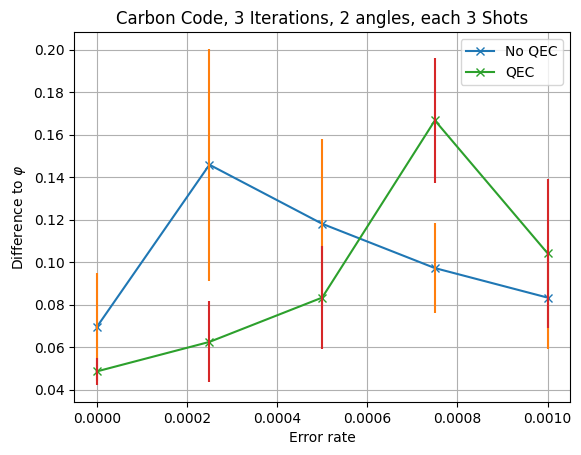

In [21]:
plt.figure(dpi=100)
plt.plot(p, y_all, marker="x",label="No QEC")
plt.errorbar(p,y_all,yerr=err,linestyle="")

plt.plot(p, y_all1, marker="x",label="QEC")
plt.errorbar(p,y_all1,yerr=err1,linestyle="")

plt.xlabel("Error rate")
plt.ylabel(r"Difference to $\varphi$")
plt.title("Carbon Code, 3 Iterations, 2 angles, each 3 Shots")
plt.grid()
plt.legend()
plt.show()

In [ ]:
qc, q, tracker = code_ft()      #third iteration iQPE

n = [0]

X_L(qc, q, 1)
H_L(qc, q, 0)
#############################
CT_L(qc, q, n, tracker, err=False)
###############################
qec_ft(qc, q, tracker)
adj_T_L(qc, q, 0)
H_L(qc, q, 0)
#qec_ft(qc, q, tracker)

gates(qc)

print(tracker)

shots = 1000
counts, cbits = readout(qc, shots, q, 0.01)

print(tracker)

result = fullpp_ft(counts, shots, cbits, tracker, True)

print("Preselected: ", result[0]*100, "%")

print("Postselected: ", result[2]*100, "%")
print("Two qubit error: ", result[1]*100, "%")
print("00: ", result[3]*100, "%")
print("01: ", result[4]*100, "%")
print("10: ", result[5]*100, "%")
print("11: ", result[6]*100, "%")
if result[5]+result[3]+result[6]+result[4] != 0:
    print("Successrate: ", (result[3]+ result[4])/(result[5]+result[3]+result[6]+result[4]))

Amount of gates in this circuit:  877
['qf']
['qf']
['000001101010 0000000000 0000010000 1 0000000', '011010100000 0000000000 1100100100 0 0000000', '110011111010 0000000000 0100010100 1 1000000', '110110111001 0000000000 1010000110 0 0000000', '000011001001 0000000000 0000010100 0 0010000', '010101100011 1000000000 1100000101 1 0000000', '101011111000 0000000000 1010010100 1 0000000', '000001100101 0000000000 0001000100 0 0000000', '000001101010 0100000000 0000001000 0 0000001', '010111000000 0000000000 1100100000 0 0000000', '101010101111 0000000000 1000010000 0 0000000', '101001000110 0000000000 1001000111 0 0001000', '010100111111 0000100000 0000111111 0 1010000', '101010100000 0000000000 0000011101 1 0000000', '101001010101 0000000000 1000000000 1 0000000', '101000111111 0000000000 1100100000 0 0001000', '000100110001 0000000000 1100100100 1 0000000', '110000001111 0001000000 0100111110 1 1010000', '000000111111 0000000000 0000000001 0 0000000', '010101100011 0000000000 0111001001

In [8]:
qc, q, tracker = code_ft()      #first iteration iQPE, with 0.3 angle, U2 eqauls 0.15 rotation

n = [0]

X_L(qc, q, 1)
H_L(qc, q, 0)
#############################
for i in range(4):
    CU_L(qc, q, n, tracker, err=True)
###############################
qec_ft(qc, q, tracker)
H_L(qc, q, 0)
qec_ft(qc, q, tracker)

gates(qc)
print("Depth of the circuit: ", qc.depth())

print(tracker)

shots = 100
counts, cbits = readout(qc, shots, q, 0.0005)

print(tracker)

result = fullpp_ft(counts, shots, cbits, tracker, True)

print("Preselected: ", result[0]*100, "%")

print("Postselected: ", result[2]*100, "%")
print("Two qubit error: ", result[1]*100, "%")
print("00: ", result[3]*100, "%")
print("01: ", result[4]*100, "%")
print("10: ", result[5]*100, "%")
print("11: ", result[6]*100, "%")
if result[5]+result[3]+result[6]+result[4] != 0:
    print("Successrate: ", (result[3]+ result[4])/(result[5]+result[3]+result[6]+result[4]))

Amount of gates in this circuit:  19962
Depth of the circuit:  17123
['qfqfqfqfqfqfqfqfqfqfqfqfqfqf']
['qfqfqfqfqfqfqfqfqfqfqfqfqfqf']
['010110101010 0000000000 0000000000 0000000000 0110000000 0000000000 0000000000 0000000000 1110011100 0000000000 0000100000 0000000000 1011000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000011001 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0 0000000', '100100001100 0000000000 0000000000 0000000000 0000010001 0000000000 0000011101 0000000000 0000000000 0000000000 0000000100 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 1 0000000', '001111000011 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0000010100 0000000000 0000000000 000000

In [ ]:
qc, q, tracker = code_test(101)

shots = 100

n = [0]

qec_ideal(qc, q, n, tracker)

X_L(qc, q, 1)

qec_ideal(qc, q, n, tracker)

H_L(qc, q, 0, n, tracker=tracker, z_stab=True)
qec_ideal(qc, q, n, tracker)

CT_L(qc, q, n, tracker, err=True)

qec_ideal(qc, q, n, tracker)

adj_T_L(qc, q, 0, n, tracker,z_stab=True)
qec_ideal(qc, q, n, tracker)

H_L(qc, q, 0,n, tracker=tracker, z_stab=True)

qec_ideal(qc, q, n, tracker)

print(n)

counts, cbits = readout(qc, shots, q, 0.01)

result = fullpp(counts, shots, cbits, tracker)
result_1 = fullpp(counts, shots, cbits, tracker, False)

print("Preselected: ", result[0]*100, "%")

print("Postselected: ", result[2]*100, "%")
print("Two qubit error: ", result[1]*100, "%")
print("00: ", result[3]*100, "%")
print("01: ", result[4]*100, "%")
print("10: ", result[5]*100, "%")
print("11: ", result[6]*100, "%")

print("Successrate: ", (result[3]+ result[4])/(result[5]+result[3]+result[6]+result[4]))
print("Successrate (no twoqubiterror): ", (result_1[3]+ result_1[4])/(result_1[5]+result_1[3]+result_1[6]+result_1[4]))

[101]
Preselected:  28.000000000000004 %
Postselected:  5.0 %
Two qubit error:  31.0 %
00:  14.000000000000002 %
01:  1.0 %
10:  11.0 %
11:  10.0 %
Successrate:  0.41666666666666674
Successrate (no twoqubiterror):  0.3582089552238807


In [ ]:
qc, q = code()

qec_ideal(qc, q)
X_L(qc, q, 0)
qec_ideal(qc, q)
H_L(qc, q, 0)
qec_ideal(qc, q)
Z_L(qc, q, 0)
qec_ideal(qc, q)
H_L(qc, q, 0)

counts = readout(qc, 1000, q, 0.05)
result = postprocessing(counts, 1000)

print("Preselected: ", result[0]*100, "%")
print("Postselected: ", result[1]*100, "%")
print("00: ", result[2]*100, "%")
print("01: ", result[3]*100, "%")
print("10: ", result[4]*100, "%")
print("11: ", result[5]*100, "%")

print("Succesrate: ", (result[3]+ result[2])/(result[5]+result[3]+result[2]+result[4]))

Preselected:  83.0 %
Postselected:  5.3 %
00:  7.7 %
01:  0.0 %
10:  3.9 %
11:  0.1 %
Succesrate:  0.6581196581196581


In [177]:
#iQPE first iteration           93,1

qc, q = code()

#qec_ideal(qc, q)

H_L(qc, q, 0)

#qec_ideal(qc, q)s

X_L(qc, q, 1)

#qec_ideal(qc, q)

H_L(qc, q, 0)
#qec_ideal(qc, q)
CNOT_L(qc, q, 1)
H_L(qc, q, 0)

#qec_ideal(qc, q)

H_L(qc, q, 0)

#qec_ideal(qc, q)

result = readout(qc, 10000, q, 0.1)

print("Preselected: ", result[0]*100, "%")
print("Postselected: ", result[1]*100, "%")
print("00: ", result[2]*100, "%")
print("01: ", result[3]*100, "%")
print("10: ", result[4]*100, "%")
print("11: ", result[5]*100, "%")

print("Succesrate: ", (result[5]+ result[4])/(result[5]+result[3]+result[2]+result[4]))

#qc.draw("mpl")

Preselected:  89.03 %
Postselected:  10.08 %
00:  0.03 %
01:  0.44 %
10:  0.02 %
11:  0.4 %
Succesrate:  0.47191011235955044


In [45]:
#iQPE first iteration

qc, q = code()

qec_ideal(qc,q)

result = readout(qc, 1000, q, 0.0)

print("Preselected: ", result[0]*100, "%")
print("Postselected: ", result[1]*100, "%")
print("00: ", result[2]*100, "%")
print("01: ", result[3]*100, "%")
print("10: ", result[4]*100, "%")
print("11: ", result[5]*100, "%")

print("Succesrate: ", (result[5]+ result[4])/(result[5]+result[3]+result[2]+result[4]))

#qc.draw("mpl")

Preselected:  0.0 %
Postselected:  0.0 %
00:  100.0 %
01:  0.0 %
10:  0.0 %
11:  0.0 %
Succesrate:  0.0


In [68]:
data_raw = np.array([0 for i in range(10)])

hmm = [1,2,3,4,5]

ehm = [6,7,8,9,10]

print(hmm+ehm)

#data_raw = np.vstack([data_raw,hmm])

#data_raw = np.hstack([data_raw,hmm])

#np.savetxt("test.txt", data_raw, delimiter=",")

print(data_raw)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0 0 0 0 0 0 0 0 0 0]


In [153]:
# hmm = np.array([[0,0],[1,1],[2,2]])                   #das irgendwann mal hinbekommen....

# print(np.shape(hmm))

# x = [[3,3]]

# print(np.shape(x))

# y = np.insert(x,0,0,0)

# print(y)

# a = np.transpose(y)

# print(np.shape(a))

# print(a)

# lol = np.hstack([hmm,a])

#print(lol)

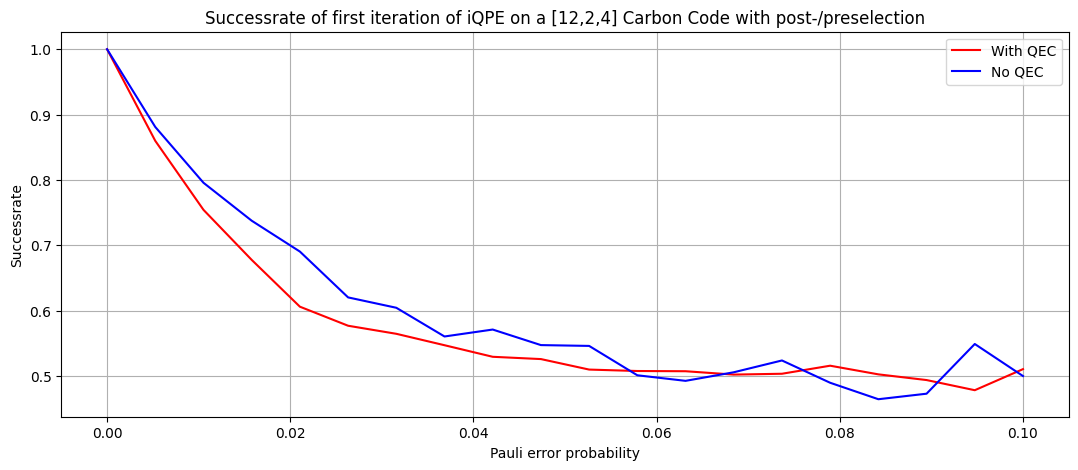

In [154]:
x = np.linspace(0,0.1,20)
y = []
y_no_QEC = []
shots = 10000
pre,pre_no_QEC, post, post_no_QEC = [],[],[],[]
data_raw = np.array([0 for i in range(12)])
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates
    
    qc, q = code()

    X_L(qc, q, 1)

    H_L(qc, q, 0)

    CZ_L(qc, q)

    H_L(qc, q, 0)

    #CNOT_L(qc, q, 1)

    result = readout(qc, shots, q, i)

    nice, total = result[4] + result[5], result[2] + result[3] + result[4] + result[5]

    if total == 0:
        y_no_QEC.append(0.5)
    else:
        y_no_QEC.append(nice/total)
    
    pre_no_QEC.append(result[0]/100)
    post_no_QEC.append(result[1]/100)

    ###############################################################################################################
    qc, q = code()

    qec_ideal(qc, q)

    H_L(qc, q, 0)

    qec_ideal(qc, q)

    X_L(qc, q, 1)

    qec_ideal(qc, q)

    H_L(qc, q, 0)
    qec_ideal(qc, q)
    CNOT_L(qc, q, 1)
    H_L(qc, q, 0)

    qec_ideal(qc, q)

    H_L(qc, q, 0)

    qec_ideal(qc, q)

    result_1 = readout(qc, shots, q, i)

    nice, total = result_1[4] + result_1[5], result_1[2] + result_1[3] + result_1[4] + result_1[5]

    if total == 0:
        y.append(0.5)
    else:
        y.append(nice/total)
    pre.append(result_1[0]/100)
    post.append(result_1[1]/100)

    hmm = result + result_1
    data_raw = np.vstack([data_raw,hmm])

data = np.array((pre,pre_no_QEC,post,post_no_QEC,x,y,y_no_QEC))
#np.savetxt("Plots/text/Carbon_1st_depol_10k.txt", data, delimiter=",")
# x_1 = np.insert(x, 0, 0)
# x_1 = np.transpose(x_1)
# data_raw = np.hstack([data_raw,x_1])
np.savetxt("Plots/text/RAW_Carbon_1st_Pauli_10k.txt", data_raw, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC,label = "No QEC", color="blue")
plt.title("Successrate of first iteration of iQPE on a [12,2,4] Carbon Code with post-/preselection")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()

In [21]:
qc, q = code()                      #92,4

qec_ideal(qc, q)

H_L(qc, q, 0)
qec_ideal(qc, q)

X_L(qc, q, 1)
qec_ideal(qc, q)

T_L(qc, q, 0)
qec_ideal(qc, q)
T_L(qc, q, 1)
qec_ideal(qc, q)
CNOT_L(qc, q, 0)
adj_T_L(qc, q, 1)
qec_ideal(qc, q)
CNOT_L(qc, q, 0)

adj_S_L(qc, q, 0)
qec_ideal(qc, q)

H_L(qc, q, 0)
qec_ideal(qc, q)

result = readout(qc, 1000, q, 0.005)

print("Preselected: ", result[0], "%")
print("Postselected: ", result[1], "%")
print("00: ", result[2], "%")
print("01: ", result[3], "%")
print("10: ", result[4], "%")
print("11: ", result[5], "%")

print("Succesrate: ", (result[2]+ result[3])/(result[5]+result[3]+result[2]+result[4]))

#qc.draw("mpl")

Preselected:  16.8 %
Postselected:  0.6 %
00:  0.0 %
01:  73.4 %
10:  0.0 %
11:  9.2 %
Succesrate:  0.8886198547215496


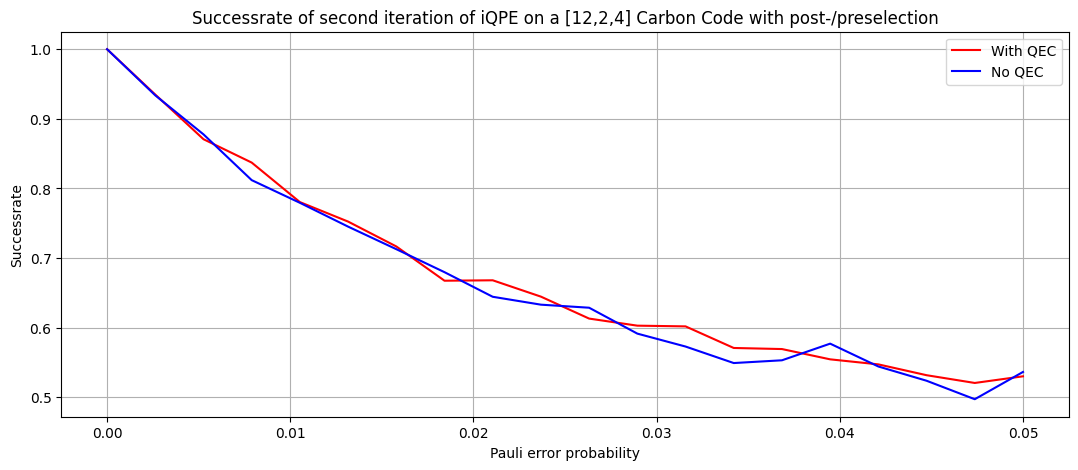

In [155]:
x = np.linspace(0,0.05,20)
y = []
y_no_QEC = []
pre,pre_no_QEC, post, post_no_QEC = [],[],[],[]
data_raw = np.array([0 for i in range(12)])
shots = 10000
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates
    
    qc, q = code()

    H_L(qc, q, 0)

    X_L(qc, q, 1)

    CS_L(qc, q)
    adj_S_L(qc, q, 0)

    H_L(qc, q, 0)

    #CNOT_L(qc, q, 1)

    result = readout(qc, shots, q, i)

    nice, total = result[2] + result[3], result[2] + result[3] + result[4] + result[5]

    if total == 0:
        y_no_QEC.append(0.5)
    else:
        y_no_QEC.append(nice/total)
    pre_no_QEC.append(result[0]/100)
    post_no_QEC.append(result[1]/100)

    ###############################################################################################################

    qc, q = code()                      #92,4

    qec_ideal(qc, q)

    H_L(qc, q, 0)
    qec_ideal(qc, q)

    X_L(qc, q, 1)
    qec_ideal(qc, q)

    T_L(qc, q, 0)
    qec_ideal(qc, q)
    T_L(qc, q, 1)
    qec_ideal(qc, q)
    CNOT_L(qc, q, 0)
    adj_T_L(qc, q, 1)
    qec_ideal(qc, q)
    CNOT_L(qc, q, 0)

    adj_S_L(qc, q, 0)
    qec_ideal(qc, q)

    H_L(qc, q, 0)
    qec_ideal(qc, q)


    result_1 = readout(qc, shots, q, i)

    nice, total = result_1[2] + result_1[3], result_1[2] + result_1[3] + result_1[4] + result_1[5]

    if total == 0:
        y.append(0.5)
    else:
        y.append(nice/total)

    pre.append(result_1[0]/100)
    post.append(result_1[1]/100)

    hmm = result + result_1
    data_raw = np.vstack([data_raw,hmm])

data = np.array((pre,pre_no_QEC,post,post_no_QEC,x,y,y_no_QEC))
#np.savetxt("Plots/text/Carbon_2nd_depol_10k.txt", data, delimiter=",")
np.savetxt("Plots/text/RAW_Carbon_2nd_Pauli_10k.txt", data_raw, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC,label = "No QEC", color="blue")
plt.title("Successrate of second iteration of iQPE on a [12,2,4] Carbon Code with post-/preselection")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()

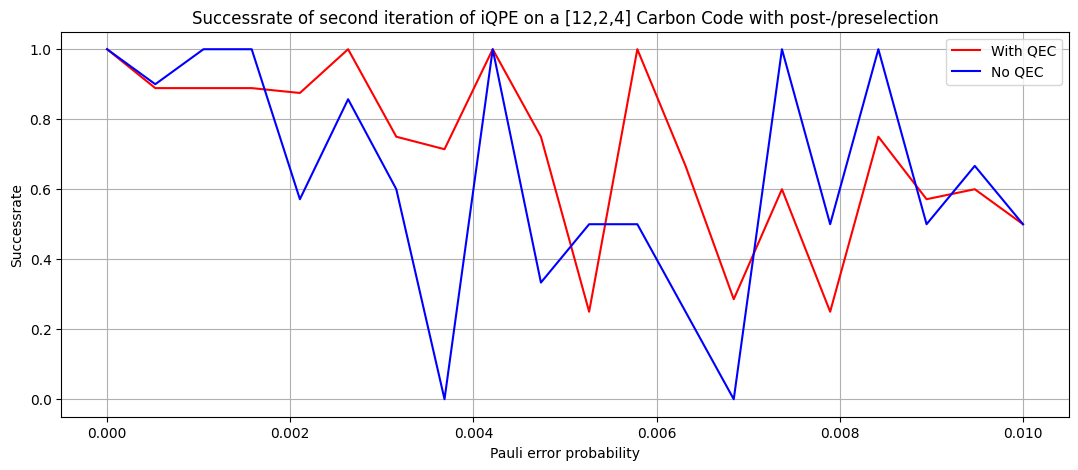

In [130]:
x = np.linspace(0,0.01,20)
y = []
y_no_QEC = []
pre, post, nn, ne, en, ee, pre2, two, post2, nn2, ne2, ee2, en2 = [],[],[],[],[],[],[],[],[],[],[],[],[]
shots = 10
for i in x:
    qc, q, tracker = code_test(0)

    n = [0]
    X_L(qc, q, 1)
    H_L(qc, q, 0, n, tracker=tracker, z_stab=False)
    CT_L(qc, q, n, tracker, err=False)
    adj_T_L(qc, q, 0, n, tracker,z_stab=False)
    H_L(qc, q, 0,n, tracker=tracker, z_stab=False)

    counts, cbits = readout_2(qc, shots, q, i)

    result = fullpp(counts, shots, cbits, tracker, False)

    nice, total = result[3] + result[4], result[3] + result[6] + result[4] + result[5]
    if total == 0:
        y_no_QEC.append(0.5)
    else:
        y_no_QEC.append(nice/total)

    pre.append(result[0]), post.append(result[2]), nn.append(result[3]), ne.append(result[4]), en.append(result[5]), ee.append(result[6])

    ###############################################################################################################

    qc, q, tracker = code_test(101)

    n = [0]
    qec_ideal(qc, q, n, tracker)
    X_L(qc, q, 1)
    qec_ideal(qc, q, n, tracker)
    H_L(qc, q, 0, n, tracker=tracker, z_stab=True)
    qec_ideal(qc, q, n, tracker)
    CT_L(qc, q, n, tracker, err=True)
    qec_ideal(qc, q, n, tracker)
    adj_T_L(qc, q, 0, n, tracker,z_stab=True)
    qec_ideal(qc, q, n, tracker)
    H_L(qc, q, 0,n, tracker=tracker, z_stab=True)

    counts, cbits = readout_2(qc, shots, q, i)

    result_1 = fullpp(counts, shots, cbits, tracker)

    nice, total = result_1[3] + result_1[4], result_1[6] + result_1[3] + result_1[4] + result_1[5]

    if total == 0:
        y.append(0.5)
    else:
        y.append(nice/total)

    pre2.append(result_1[0]), two.append(result_1[1]), post2.append(result_1[2]), nn2.append(result_1[3]), ne2.append(result_1[4]), en2.append(result_1[5]), ee2.append(result_1[6])

data = np.array((x,pre,post,nn,ne,en,ee,pre2,two,post2,nn2,ne2,en2,ee2))
#np.savetxt("Plots/text/Carbon_2nd_depol_10k.txt", data, delimiter=",")
#np.savetxt("Plots/text/RAW_Carbon_2nd_Pauli_10k.txt", data_raw, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC,label = "No QEC", color="blue")
plt.title("Successrate of second iteration of iQPE on a [12,2,4] Carbon Code with post-/preselection")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()

In [ ]:


def Dustin(iter: int, n:int, noise: float, k = 1):
    angle = np.linspace(0,1,n+2)
    angle = np.delete(angle, [n+1])
    angle = np.delete(angle, [0])

    a, b = [], []
    with open("unitary{}.txt".format(n), "r") as file:
        for line in file:
            a.append(list(map(str, line.strip().split(","))))
    with open("adjunitary{}.txt".format(n), "r") as file:
        for line in file:
            b.append(list(map(str, line.strip().split(","))))
    
    y = 0
    for o in range(len(a)):
        qr = QuantumRegister(2,"q")
        cbit = ClassicalRegister(iter, "c")
        qc = QuantumCircuit(qr, cbit)

        p = noise
        p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
        p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "s", "sdg", "t", "tdg", "rz"])  # Apply to single-qubit gates
        noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

        for i in range(iter):
            qc.reset(0), qc.reset(1)
            qc.x(1)
            qc.h(0)
            for j in range(iter-i-1):
                CU_L(qc, a[o], b[o])

            for j in range(i):
                with qc.if_test((j,1)):
                    qc.rz(-2*np.pi*(2**(-i+j)),0)

            qc.h(0)
            qc.measure(0,i)

        shots = k
        sim = AerSimulator()
        job = sim.run(qc, shots=shots, noise_model=noise_model)
        result = job.result()
        counts = result.get_counts()
        bits = list(counts.keys())   
        value = list(counts.values())
        
        for i in range(len(bits)):
            hmm = convert(bits[i])
            diff = np.abs(hmm-angle[o])
            y += diff*value[i]
    y = y/(len(angle)*k)
    return y
